In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


In [ ]:
snrs = [l.snr for l in detectable_lenses]

In [5]:
# Create a histogram from the snrs list using numpy
hist, bin_edges = np.histogram(snrs, bins=50)

# Print the histogram and bin edges
print("Histogram:", hist)
print("Bin edges:", bin_edges)

Histogram: [5549 2415 2036 1815 1088  623  378  256  156   95   74   61   30   26
   22   17   19   12   12    6    4    1    1    2    2    0    0    1
    1    0    1    0    0    0    1    0    0    0    0    0    1    0
    0    0    0    0    0    0    0    1]
Bin edges: [ 20.00216678  31.74355222  43.48493766  55.2263231   66.96770854
  78.70909398  90.45047942 102.19186486 113.9332503  125.67463574
 137.41602118 149.15740662 160.89879206 172.6401775  184.38156294
 196.12294838 207.86433382 219.60571926 231.3471047  243.08849014
 254.82987558 266.57126103 278.31264647 290.05403191 301.79541735
 313.53680279 325.27818823 337.01957367 348.76095911 360.50234455
 372.24372999 383.98511543 395.72650087 407.46788631 419.20927175
 430.95065719 442.69204263 454.43342807 466.17481351 477.91619895
 489.65758439 501.39896983 513.14035527 524.88174071 536.62312616
 548.3645116  560.10589704 571.84728248 583.58866792 595.33005336
 607.0714388 ]


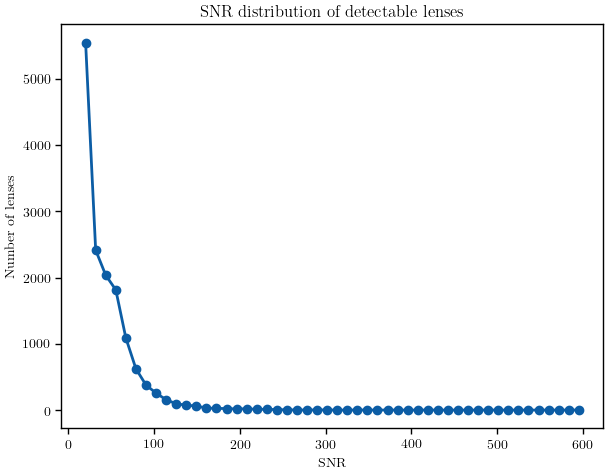

In [6]:
plt.plot(bin_edges[:-1], hist, linestyle='-', marker='o')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses')
plt.show()

Optimal parameters: [1.11356636e+04 3.86340080e-02 1.21295184e+01]
Covariance of parameters: [[4.42954821e+05 1.22333769e+00 2.73962786e+03]
 [1.22333769e+00 4.11200083e-06 1.59339048e-02]
 [2.73962786e+03 1.59339048e-02 6.26672292e+02]]


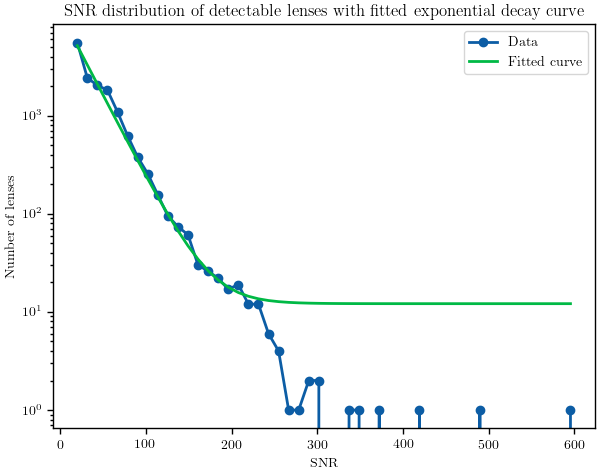

In [14]:
from scipy.optimize import curve_fit

# Define the exponential decay function
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the exponential decay curve to the histogram data
popt, pcov = curve_fit(exponential_decay, bin_edges[:-1], hist, p0=(1, 1e-6, 1))

# Print the optimal parameters
print("Optimal parameters:", popt)
print("Covariance of parameters:", pcov)

# Plot the histogram and the fitted curve
plt.plot(bin_edges[:-1], hist, linestyle='-', marker='o', label='Data')
plt.plot(bin_edges[:-1], exponential_decay(bin_edges[:-1], *popt), label='Fitted curve')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses with fitted exponential decay curve')
plt.legend()
plt.yscale('log')
plt.show()

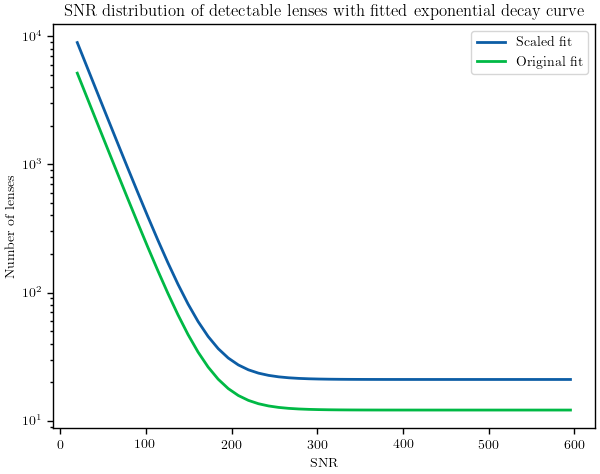

In [13]:
plt.plot(bin_edges[:-1], np.sqrt(3) * exponential_decay(bin_edges[:-1], *popt), label='Scaled fit')
plt.plot(bin_edges[:-1], exponential_decay(bin_edges[:-1], *popt), label='Original fit')
plt.xlabel('SNR')
plt.ylabel('Number of lenses')
plt.title('SNR distribution of detectable lenses with fitted exponential decay curve')
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
from scipy.integrate import quad

# Define the function to integrate
def integrand(x):
    return np.sqrt(4) * exponential_decay(x, *popt)

# Perform the integration from 20 to infinity
result, error = quad(integrand, 20, np.inf)

# Print the result and the error
print("Integral result:", result)
print("Integration error:", error)

Integral result: 266174.24021987617
Integration error: 4.509062273427844e-05


In [16]:
# Perform the integration from 200 to infinity
result_200, error_200 = quad(integrand, 200, np.inf)

# Print the result and the error
print("Integral result from 200 to infinity:", result_200)
print("Integration error from 200 to infinity:", error_200)

Integral result from 200 to infinity: 229.87862949175994
Integration error from 200 to infinity: 4.104134632143541e-08


that's definitely inaccurate because of insufficient samples at higher SNRs

In [17]:
# Define the function to integrate using histogram data
def hist_integrand(x):
    bin_index = np.digitize(x, bin_edges) - 1
    if bin_index >= len(hist):
        return 0
    return np.sqrt(4) * hist[bin_index]

# Perform the integration from 200 to infinity
hist_result_200, hist_error_200 = quad(hist_integrand, 200, np.inf)

# Print the result and the error
print("Integral result from 200 to infinity using histogram data:", hist_result_200)
print("Integration error from 200 to infinity using histogram data:", hist_error_200)

Integral result from 200 to infinity using histogram data: 1697.9471242625466
Integration error from 200 to infinity using histogram data: 37.87869330267813
